In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense, Dropout
from sklearn.decomposition import MiniBatchSparsePCA
import random
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns


direc = "C:/Users/chsue/Documents/MITyear3/6.047/GDACLAMLmethyl450/data/"
GSE41169controlcols = ['"GSM1009' + x +'"' for x in ["666","667","668","673","674","677","681","685","686","687","688","689","690","691","692","693","694","695","697","723",
                       "727","729","739","742","743","744","745","746","747","748","749","892","893"]]

GSE63499controlcols = ['"GSM1551' + x +'"' for x in ["110","114","118","122","126","132","136","140","144","148","152","156"]]

GSE64495controlcols = ['"GSM157250' + str(x) +'"' for x in range(3,10)] + ['"GSM15725' + str(x) +'"' for x in range(10,65)]

GSE64934cols = ['"GSM1584043"','"GSM1584044"','"GSM1584045"','"GSM1584046"','"GSM1584047"','"GSM1584048"']
control1Cols = ["1B","2A","3B","3","5","13","19","10","12","14","2","239","200","181","195","308","310","8B","10A","11B"]
GSE64934cols = ['"GSM1584043"','"GSM1584044"','"GSM1584045"','"GSM1584046"','"GSM1584047"','"GSM1584048"']
# first three are some FLT3 ITD and then the last three are WT

import numpy as np

def process_cancer(chunk):
    chunk = chunk.set_index("Hybridization REF")
    if "Composite Element REF" in chunk.index:
        chunk = chunk.drop("Composite Element REF", axis=0)
    return chunk.apply(pd.to_numeric).round(2)

def process_control_1(chunk):
    return chunk.set_index("ID_REF").round(2)

def process_control_2(chunk):
    return chunk.set_index("ID_REF").round(2)

def process_control_3(chunk):
    return chunk.set_index("ID_REF").round(2)

def importControl1(): ## Crohn's control
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE32148_matrix_processed_peripheralBlood.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + control1Cols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i,chunk in enumerate(pd.read_table(direc+"GSE32148_matrix_processed_peripheralBlood.txt",chunksize=4500,delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 1 ", i)
        controlRows.append(process_control_1(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl2(): # dutch study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE41169_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE41169controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE41169_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 2", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl3(): # smoker study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE53045_matrix_processed_GEO.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + ["GSM1280" + str(937+x) for x in range(0,27)]+["GSM1280" + str(991+x) for x in range(0,9)] + ["GSM128" + str(1000+x) for x in range(0,25)]
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE53045_matrix_processed_GEO.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 3 ", i)
        controlRows.append(process_control_3(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl4(): # folic acid study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE63499_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE63499controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE63499_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 4 ", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl5(): # developmental study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE64495_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE64495controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE64495_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 5 ", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importTestControl():
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE51388_series_matrix.txt", nrows=0).columns)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE51388_series_matrix.txt", chunksize=4500, delimiter=r"\t+",dtype=types_dict)):
        print("Test control ", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importCancer():
    cancerRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"LAMLmethyl450.txt", nrows=0).columns)
    relevant_cols = [0] + list(range(1,len(col_names),4))
    types_dict = {"Hybridization REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i,chunk in enumerate(pd.read_table(direc+"LAMLmethyl450.txt", chunksize=4500, dtype=types_dict,usecols=relevant_cols)):
        print("Cancer ",i)
        cancerRows.append(process_cancer(chunk))
        if i==0: namesRows=list(chunk.columns)
    cancerRows = pd.concat(cancerRows, names=namesRows,axis=0)
    cancerRows = cancerRows.transpose()
    cancerRows = pd.concat([cancerRows,pd.DataFrame([1] * cancerRows.shape[0],columns=["Cancer"],index=cancerRows.index)],axis=1)
    cancerRows = pd.concat([cancerRows,pd.DataFrame([0] * cancerRows.shape[0],columns=["Not Cancer"],index=cancerRows.index)],axis=1)
    return cancerRows

def importTestCancer():
    cancerRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE64934_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE64934cols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE64934_series_matrix.txt", chunksize=4500, delimiter=r"\t+",dtype=types_dict,usecols=relevant_cols)):
        print("Test cancer ", i)
        cancerRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    cancerRows = pd.concat(cancerRows, names=namesRows,axis=0)
    cancerRows = cancerRows.transpose()
    cancerRows = pd.concat([cancerRows,pd.DataFrame([1] * cancerRows.shape[0],columns=["Cancer"],index=cancerRows.index)],axis=1)
    cancerRows = pd.concat([cancerRows,pd.DataFrame([0] * cancerRows.shape[0],columns=["Not Cancer"],index=cancerRows.index)],axis=1)
    return cancerRows

C:\Users\chsue\AppData\Roaming\Python\Python35\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_nn_model(input_length):
    m = Sequential()
    m.add(Dense(units=1024, activation="relu",input_shape=(input_length,)))
    m.add(Dense(units=512, activation="relu"))
    m.add(Dense(units=512, activation="relu"))
    m.add(Dense(units=2, activation="softmax"))
    m.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])
    return m

def create_svm():
    clf = SVC(gamma='auto', probability=True)
    return clf

In [ ]:
trainingNames = ['TCGA-AB-2861-03A-01D-0741-05','TCGA-AB-2846-03A-01D-0741-05','TCGA-AB-2930-03A-01D-0743-05','"GSM1572554"','"GSM1009666"','GSM1280946',
 '"GSM1572531"','GSM1281007','"GSM1009685"','TCGA-AB-2857-03A-01D-0741-05','"GSM1572513"','"GSM1572508"','GSM1280952','"GSM1572543"',
 '"GSM1572506"','TCGA-AB-2968-03A-01D-0741-05','"GSM1009748"','"GSM1009677"','TCGA-AB-2875-03A-01D-0742-05','TCGA-AB-2943-03A-01D-0743-05',
 '"GSM1572528"','TCGA-AB-2931-03A-01D-0743-05','"GSM1572550"','"GSM1572519"','"GSM1009668"','TCGA-AB-3002-03A-01D-0742-05','TCGA-AB-2992-03A-01D-0741-05',
 'TCGA-AB-2917-03A-01D-0741-05','"GSM1572558"','TCGA-AB-2845-03A-01D-0741-05','GSM1280997','TCGA-AB-2835-03A-01D-0741-05','GSM1280991','TCGA-AB-2804-03A-01D-0741-05',
 '10A','"GSM1572545"','TCGA-AB-2946-03A-01D-0743-05','"GSM1551152"','TCGA-AB-2891-03A-01D-0742-05','TCGA-AB-2851-03A-01D-0741-05',
 'TCGA-AB-2887-03A-01D-0742-05','"GSM1572538"','"GSM1572563"','TCGA-AB-2811-03A-01D-0741-05','GSM1280957','"GSM1572529"','GSM1281021',
 'GSM1281012','TCGA-AB-2892-03A-01D-0742-05','"GSM1009687"','TCGA-AB-2860-03A-01D-0741-05','TCGA-AB-2890-03A-01D-0742-05','TCGA-AB-2834-03A-01D-0741-05',
 'TCGA-AB-2912-03A-01D-0741-05','TCGA-AB-2814-03A-01D-0741-05','TCGA-AB-2823-03A-01D-0741-05','TCGA-AB-2919-03A-01D-0743-05','TCGA-AB-2990-03A-01D-0742-05',
 'TCGA-AB-2884-03A-01D-0742-05','"GSM1572535"','"GSM1009729"','TCGA-AB-2876-03A-01D-0742-05','TCGA-AB-2829-03A-01D-0741-05','GSM1281005','TCGA-AB-2996-03A-01D-0741-05',
 '"GSM1551118"','TCGA-AB-2971-03A-01D-0741-05','TCGA-AB-2882-03A-01D-0742-05','TCGA-AB-2944-03A-01D-0743-05','GSM1280960','TCGA-AB-2915-03A-01D-0743-05',
 'TCGA-AB-2936-03A-01D-0743-05','TCGA-AB-2896-03A-01D-0742-05','GSM1280953','TCGA-AB-3005-03A-01D-0741-05','"GSM1572533"','"GSM1572553"',
 'TCGA-AB-2918-03A-01D-0743-05','TCGA-AB-2833-03A-01D-0741-05','GSM1280951','"GSM1572539"','GSM1280947','"GSM1572515"',
 '3','"GSM1572561"','GSM1280944','GSM1280962','"GSM1572524"','TCGA-AB-2933-03A-01D-0742-05','TCGA-AB-3012-03A-01D-0741-05','TCGA-AB-2817-03A-01D-0742-05',
 'TCGA-AB-2940-03A-01D-0742-05','TCGA-AB-2897-03A-01D-0742-05','TCGA-AB-2873-03A-01D-0742-05','GSM1281018','TCGA-AB-2955-03A-01D-0742-05',
 'TCGA-AB-2904-03A-01D-0741-05','TCGA-AB-2963-03A-01D-0741-05','"GSM1009745"','TCGA-AB-2947-03A-01D-0743-05','GSM1280994',
 'TCGA-AB-2972-03A-01D-0741-05','1B','TCGA-AB-2993-03A-01D-0741-05','TCGA-AB-2998-03A-01D-0742-05','GSM1280938','TCGA-AB-2987-03A-01D-0742-05',
 'TCGA-AB-2964-03A-01D-0741-05','195','"GSM1551114"','GSM1280995','"GSM1009693"','GSM1281000','"GSM1009674"','"GSM1572552"','13',
 'TCGA-AB-2893-03A-01D-0742-05','TCGA-AB-2989-03A-01D-0742-05','TCGA-AB-2923-03A-01D-0743-05','TCGA-AB-2929-03A-01D-0741-05','GSM1280941',
 'TCGA-AB-2869-03A-01D-0742-05','"GSM1572516"','TCGA-AB-2973-03A-01D-0742-05','"GSM1009695"','TCGA-AB-2802-03A-01D-0741-05','"GSM1009667"',
 'GSM1281006','TCGA-AB-2886-03A-01D-0742-05','TCGA-AB-2866-03A-01D-0741-05','"GSM1572520"','"GSM1572534"','TCGA-AB-2867-03A-01D-0741-05',
 'TCGA-AB-2828-03A-01D-0741-05','"GSM1009697"','TCGA-AB-2986-03A-01D-0742-05','GSM1281002','TCGA-AB-2924-03A-01D-0743-05','TCGA-AB-2874-03A-01D-0742-05',
 'GSM1281010','TCGA-AB-2888-03A-01D-0742-05','TCGA-AB-2810-03A-01D-0741-05','GSM1280993','TCGA-AB-2871-03A-01D-0742-05','"GSM1572511"',
 'GSM1280948','TCGA-AB-2925-03A-01D-0741-05','181','"GSM1572518"','TCGA-AB-2913-03A-01D-0741-05','TCGA-AB-2985-03A-01D-0742-05','TCGA-AB-2883-03A-01D-0742-05',
 '"GSM1009893"','TCGA-AB-2934-03A-01D-0743-05','TCGA-AB-2837-03A-01D-0741-05','TCGA-AB-2844-03A-01D-0741-05','TCGA-AB-2907-03A-01D-0742-05','TCGA-AB-2895-03A-01D-0742-05',
 'TCGA-AB-2878-03A-01D-0742-05','TCGA-AB-2999-03A-01D-0742-05','GSM1280955','11B','"GSM1551110"','TCGA-AB-2898-03A-01D-0742-05','TCGA-AB-2881-03A-01D-0742-05','GSM1280954',
 '308','"GSM1572503"','239','TCGA-AB-3007-03A-01D-0741-05','TCGA-AB-3001-03A-01D-0741-05','TCGA-AB-2945-03A-01D-0741-05','TCGA-AB-2842-03A-01D-0741-05',
 'GSM1280950','"GSM1572517"','TCGA-AB-2822-03A-01D-0741-05','"GSM1572514"','TCGA-AB-2949-03A-01D-0742-05','TCGA-AB-2843-03A-01D-0741-05',
 'TCGA-AB-2941-03A-01D-0743-05','TCGA-AB-2894-03A-01D-0742-05','TCGA-AB-2997-03A-01D-0742-05','"GSM1009691"','3B','"GSM1572527"','TCGA-AB-2908-03A-01D-0743-05',
 '"GSM1572510"','TCGA-AB-2848-03A-01D-0741-05','TCGA-AB-2862-03A-01D-0741-05','"GSM1572549"','TCGA-AB-2847-03A-01D-0741-05','"GSM1572541"',
 '"GSM1551126"','TCGA-AB-2820-03A-01D-0741-05','"GSM1551122"','200','2','"GSM1572551"','TCGA-AB-2950-03A-01D-0742-05','GSM1280939','TCGA-AB-2966-03A-01D-0741-05',
 'GSM1281017','"GSM1551136"','19','GSM1281001','"GSM1009892"','TCGA-AB-2920-03A-01D-0742-05','GSM1280998','"GSM1572547"','TCGA-AB-2853-03A-01D-0741-05',
 'TCGA-AB-2977-03A-01D-0742-05','TCGA-AB-2885-03A-01D-0742-05','"GSM1572504"','"GSM1009689"','GSM1280961','TCGA-AB-2838-03A-01D-0741-05',
 'GSM1280999','"GSM1572564"','GSM1281014','TCGA-AB-2921-03A-01D-0743-05','TCGA-AB-2942-03A-01D-0742-05','"GSM1572560"','TCGA-AB-3000-03A-01D-0741-05','"GSM1009744"',
 'GSM1280943','TCGA-AB-2877-03A-01D-0742-05','TCGA-AB-2855-03A-01D-0741-05','"GSM1009690"','"GSM1572512"','TCGA-AB-2806-03A-01D-0741-05','TCGA-AB-2840-03A-01D-0741-05',
 'TCGA-AB-2826-03A-01D-0741-05','GSM1280942','"GSM1551156"','TCGA-AB-2965-03A-01D-0741-05','TCGA-AB-2836-03A-01D-0741-05','"GSM1009688"','GSM1281019','GSM1280963',
 '12','TCGA-AB-2981-03A-01D-0742-05','"GSM1572555"','TCGA-AB-2969-03A-01D-0741-05','TCGA-AB-2980-03A-01D-0742-05','"GSM1009694"','TCGA-AB-2959-03A-01D-0741-05',
 'TCGA-AB-2824-03A-01D-0741-05','TCGA-AB-2916-03A-01D-0742-05','TCGA-AB-2868-03A-01D-0741-05','GSM1281004','TCGA-AB-2911-03A-01D-0741-05',
 '"GSM1572556"','TCGA-AB-2805-03A-01D-0741-05','10','TCGA-AB-2901-03A-01D-0742-05','"GSM1572526"','TCGA-AB-3009-03A-01D-0741-05','"GSM1572548"',
 'TCGA-AB-2839-03A-01D-0741-05','TCGA-AB-2854-03A-01D-0741-05','TCGA-AB-2938-03A-01D-0741-05','GSM1281009','TCGA-AB-2808-03A-01D-0741-05','TCGA-AB-2991-03A-01D-0741-05',
 '"GSM1572509"','"GSM1572525"','TCGA-AB-2812-03A-01D-0741-05','"GSM1572557"','GSM1280996','TCGA-AB-2956-03A-01D-0741-05','TCGA-AB-2935-03A-01D-0743-05',
 'GSM1280956','"GSM1572544"','TCGA-AB-2872-03A-01D-0742-05','TCGA-AB-2821-03A-01D-0741-05','TCGA-AB-2880-03A-01D-0742-05','"GSM1572523"',
 'TCGA-AB-2816-03A-01D-0742-05','"GSM1009723"','TCGA-AB-2926-03A-01D-0742-05','GSM1280949','TCGA-AB-2813-03A-01D-0741-05','TCGA-AB-3006-03A-01D-0741-05',
 'TCGA-AB-2928-03A-01D-0743-05','TCGA-AB-2841-03A-01D-0741-05','"GSM1572507"','"GSM1572546"','2A','"GSM1572522"','TCGA-AB-2900-03A-01D-0742-05','"GSM1009742"',
 'TCGA-AB-2974-03A-01D-0742-05','TCGA-AB-2910-03A-01D-0743-05','"GSM1572521"','GSM1280959','"GSM1572505"','TCGA-AB-2927-03A-01D-0743-05','TCGA-AB-2858-03A-01D-0741-05',
 '310','"GSM1572542"','TCGA-AB-2825-03A-01D-0741-05','TCGA-AB-2818-03A-01D-0741-05','TCGA-AB-2982-03A-01D-0742-05','TCGA-AB-2922-03A-01D-0743-05','"GSM1009739"']

In [ ]:
### importing data, processing (Run #1)
cancerData = importCancer()
control1Data = importControl1()
control2Data = importControl2()
control2Data.columns = [column.replace('\"', '') for column in list(control2Data.columns)]
control3Data = importControl3()
control4Data = importControl4()
control4Data.columns = [column.replace('\"', '') for column in list(control4Data.columns)]
control5Data = importControl5()
control5Data.columns = [column.replace('\"', '') for column in list(control5Data.columns)]
totalData = pd.concat([cancerData,control1Data,control2Data,control3Data,control4Data,control5Data])
totalData = totalData.dropna(axis=1)

C:\Users\chsue\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (1,5,513,9,13,685,529,21,601,537,29,517,33,549,689,41,45,605,49,53,521,57,769,573,693,65,581,97,585,77,525,81,85,697,89,93,101,609,613,17,105,621,701,113,629,617,121,125,533,641,133,705,649,141,109,657,661,25,665,669,709,161,677,625,169,173,541,177,773,181,713,185,189,117,193,197,545,201,205,717,209,213,633,217,221,37,225,229,721,233,237,637,241,245,553,249,253,725,257,261,129,265,269,557,273,277,729,281,285,645,289,293,561,297,301,733,305,309,137,313,317,565,321,325,737,329,333,653,337,341,569,345,349,741,353,357,145,361,365,61,369,373,745,377,381,149,385,389,577,393,397,749,401,405,153,409,413,69,417,421,753,425,429,157,433,437,73,441,445,757,449,453,673,457,461,589,465,469,761,473,477,165,481,485,593,489,493,765,497,501,681,505,509,597) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Cancer  0
Cancer  1
Cancer  2
Cancer  3
Cancer  4
Cancer  5
Cancer  6
Cancer  7
Cancer  8
Cancer  9
Cancer  10
Cancer  11
Cancer  12
Cancer  13
Cancer  14
Cancer  15
Cancer  16
Cancer  17
Cancer  18
Cancer  19
Cancer  20
Cancer  21
Cancer  22
Cancer  23
Cancer  24
Cancer  25
Cancer  26
Cancer  27
Cancer  28
Cancer  29
Cancer  30
Cancer  31
Cancer  32
Cancer  33
Cancer  34
Cancer  35
Cancer  36
Cancer  37
Cancer  38
Cancer  39
Cancer  40
Cancer  41
Cancer  42
Cancer  43
Cancer  44
Cancer  45
Cancer  46
Cancer  47
Cancer  48
Cancer  49
Cancer  50
Cancer  51


In [9]:
### import independent test data and figure out intersection of CpG sites that are non-NA (Run #2)
totalDataCpGIndices = list(totalData.columns)
testControlData = importTestControl()
testControlData.columns = [column.replace('\"', '') for column in list(testControlData.columns)]
testCancerData = importTestCancer()
testCancerData.columns = [column.replace('\"', '') for column in list(testCancerData.columns)]
independentTestData = pd.concat([testCancerData,testControlData])
independentTestData = independentTestData.dropna(axis=1)
independentTestDataCpGIndices = set(list(independentTestData.columns))
commonCpGSites = list(set(totalDataCpGIndices).intersection(independentTestDataCpGIndices))

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:142: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Test control  0
Test control  1
Test control  2
Test control  3
Test control  4
Test control  5
Test control  6
Test control  7
Test control  8
Test control  9
Test control  10
Test control  11
Test control  12
Test control  13
Test control  14
Test control  15
Test control  16
Test control  17
Test control  18
Test control  19
Test control  20
Test control  21
Test control  22
Test control  23
Test control  24
Test control  25
Test control  26
Test control  27
Test control  28
Test control  29
Test control  30
Test control  31
Test control  32
Test control  33
Test control  34
Test control  35
Test control  36
Test control  37
Test control  38
Test control  39
Test control  40
Test control  41
Test control  42
Test control  43
Test control  44
Test control  45
Test control  46
Test control  47
Test control  48
Test control  49
Test control  50
Test control  51
Test control  52
Test control  53
Test control  54
Test control  55
Test control  56
Test control  57
Test control  58
Test co

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:176: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Test cancer  2
Test cancer  3
Test cancer  4
Test cancer  5
Test cancer  6
Test cancer  7
Test cancer  8
Test cancer  9
Test cancer  10
Test cancer  11
Test cancer  12
Test cancer  13
Test cancer  14
Test cancer  15
Test cancer  16
Test cancer  17
Test cancer  18
Test cancer  19
Test cancer  20
Test cancer  21
Test cancer  22
Test cancer  23
Test cancer  24
Test cancer  25
Test cancer  26
Test cancer  27
Test cancer  28
Test cancer  29
Test cancer  30
Test cancer  31
Test cancer  32
Test cancer  33
Test cancer  34
Test cancer  35
Test cancer  36
Test cancer  37
Test cancer  38
Test cancer  39
Test cancer  40
Test cancer  41
Test cancer  42
Test cancer  43
Test cancer  44
Test cancer  45
Test cancer  46
Test cancer  47
Test cancer  48
Test cancer  49
Test cancer  50
Test cancer  51
Test cancer  52
Test cancer  53
Test cancer  54
Test cancer  55
Test cancer  56
Test cancer  57
Test cancer  58
Test cancer  59
Test cancer  60
Test cancer  61
Test cancer  62
Test cancer  63
Test cancer  64


C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
### set total data to only the shared CpG sites with test data for continuity (Run #3)
totalDataCopy = totalData
totalData = totalData.loc[:,commonCpGSites] ##end - 382 samples x 291032 cpg sites + cancer/noncancer

In [13]:
### splitting into data/labels (Run #4)
totalTrainingData = totalData.drop(["Cancer","Not Cancer"],axis=1).loc[trainingNames,:]
totalTrainingLabels = totalData.loc[trainingNames,["Cancer","Not Cancer"]]
trainingIndices = [list(totalData.index).index(name) for name in trainingNames]
testIndices = list(set(range(382)) - set(trainingIndices))
totalTestData = totalData.drop(["Cancer","Not Cancer"],axis=1).iloc[testIndices,:]
totalTestLabels = totalData.iloc[testIndices,:].loc[:,["Cancer","Not Cancer"]]

In [22]:
### determining ttest significance (Run #5A)
from scipy.stats import ttest_ind

cancer = totalData[totalData['Cancer']==0]
nonCancer = totalData[totalData['Cancer']==1]
ttest = []
for cpgSite in commonCpGSites:
    ttest.append(ttest_ind(cancer[cpgSite], nonCancer[cpgSite]))
ttest = pd.Series([t[1] for t in ttest],index=totalData.columns).drop(["Cancer","Not Cancer"])
keyCpG = ttest.nsmallest(20).index

In [109]:
### determining variances (Run #5B)
keyCpG = totalTrainingData.var(axis=0).nlargest(10).index

In [23]:
### isolating the data from the relevant cpg sites (Run #6)
totalTrainingData = totalTrainingData.loc[:,list(keyCpG)]
totalTestData = totalTestData.loc[:,list(keyCpG)]
totalTrainingDataValues = totalTrainingData.values
totalTestDataValues = totalTestData.values
totalTrainingLabelValues = totalTrainingLabels.values
totalTestLabelValues = totalTestLabels.values

In [25]:
totalTrainingData

,cg21695395,cg03795574,cg26353844,cg02464568,cg24957609,cg23462242,cg01891736,cg05456362,cg12511137,cg16567202,...,cg25261059,cg13920312,cg18545695,cg17727855,cg09827048,cg19798735,cg15324288,cg22395253,cg18373623,cg07181902
TCGA-AB-2861-03A-01D-0741-05,0.87,0.16,0.91,0.92,0.77,0.61,0.89,0.87,0.96,0.87,...,0.06,0.96,0.04,0.04,0.95,0.82,0.92,0.96,0.05,0.02
TCGA-AB-2846-03A-01D-0741-05,0.93,0.85,0.91,0.91,0.86,0.67,0.97,0.89,0.95,0.94,...,0.05,0.95,0.08,0.04,0.95,0.90,0.89,0.95,0.17,0.05
TCGA-AB-2930-03A-01D-0743-05,0.92,0.83,0.88,0.89,0.82,0.81,0.92,0.83,0.93,0.88,...,0.06,0.91,0.08,0.05,0.92,0.84,0.89,0.90,0.05,0.04
"""GSM1572554""",0.54,0.25,0.57,0.78,0.48,0.16,0.47,0.74,0.83,0.71,...,0.31,0.70,0.54,0.25,0.80,0.60,0.74,0.69,0.52,0.10
"""GSM1009666""",0.50,0.13,0.49,0.76,0.45,0.09,0.57,0.62,0.79,0.69,...,0.34,0.77,0.38,0.32,0.82,0.64,0.72,0.76,0.37,0.15
GSM1280946,0.49,0.28,0.48,0.77,0.35,0.21,0.58,0.61,0.81,0.81,...,0.20,0.69,0.36,0.24,0.85,0.43,0.75,0.77,0.38,0.11
"""GSM1572531""",0.64,0.24,0.69,0.76,0.40,0.29,0.57,0.71,0.86,0.73,...,0.27,0.81,0.47,0.21,0.84,0.69,0.68,0.80,0.45,0.11
GSM1281007,0.58,0.30,0.58,0.78,0.40,0.24,0.54,0.66,0.83,0.77,...,0.20,0.74,0.29,0.20,0.87,0.63,0.74,0.79,0.29,0.11
"""GSM1009685""",0.56,0.17,0.60,0.81,0.45,0.14,0.59,0.64,0.83,0.74,...,0.26,0.79,0.35,0.21,0.83,0.64,0.77,0.82,0.32,0.10
TCGA-AB-2857-03A-01D-0741-05,0.84,0.70,0.90,0.89,0.68,0.43,0.88,0.89,0.91,0.93,...,0.04,0.91,0.10,0.04,0.94,0.88,0.88,0.93,0.13,0.06


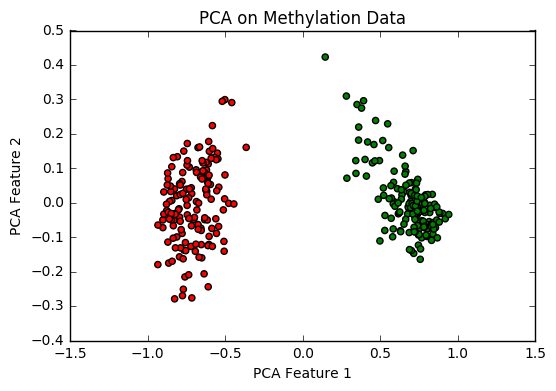

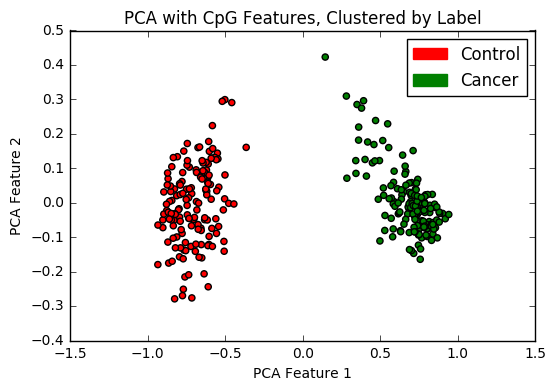

In [24]:
## PCA (Run #7)
methyl_PCA = PCA()
trainingPCAFeatures = methyl_PCA.fit_transform(totalTrainingData)
clusterer = KMeans(n_clusters=2)
cluster_labels = clusterer.fit_predict(trainingPCAFeatures)

colors = {0: "r", 1: "g"}
p = plt.scatter(trainingPCAFeatures[:, 0], trainingPCAFeatures[:, 1], c=[colors[c] for c in cluster_labels])
plt.title("PCA on Methylation Data")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

# colors_label = [0] * 190 + [1] * (len(cluster_labels) - 190)
colors_label = [0 if label[0] == 0 else 1 for label in totalTrainingLabelValues]
p1 = plt.scatter(trainingPCAFeatures[:, 0], trainingPCAFeatures[:, 1], c=[colors[c] for c in colors_label])
plt.title("PCA with CpG Features, Clustered by Label")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(handles=[mpatches.Patch(color='red', label='Control'),mpatches.Patch(color='green', label='Cancer')])
plt.show()

testPCAFeatures = methyl_PCA.transform(totalTestData)

In [27]:
#### Neural net stuff - just comment out everything except the model you wanna try and everything should work
## (Run #8)

## trying out the cpg sites (w/ NN)!!!
# model = create_nn_model(totalTrainingDataValues.shape[1])
# model.fit(totalTrainingDataValues,totalTrainingLabelValues,batch_size=32,epochs=3)
# score = model.evaluate(totalTestDataValues, totalTestLabelValues, batch_size=32)
# print("Score: ", score)

## trying out the cpg sites (w/ SVM)!!!
model = create_svm()
Y_train = totalTrainingLabelValues[:,0]
Y_test = totalTestLabelValues[:,0]
model.fit(totalTrainingDataValues,Y_train)
y_score = model.predict_proba(totalTestDataValues)
print(model.score(totalTestDataValues,Y_test))

## trying out the PCA results (w/ NN)!
# model = create_nn_model(trainingPCAFeatures[:,0:3].shape[1])
# model.fit(trainingPCAFeatures[:,0:3],totalTrainingLabelValues,batch_size=32,epochs=3)
# score = model.evaluate(testPCAFeatures[:,0:3], totalTestLabelValues, batch_size=32)
# print("Score: ", score)

## trying out the PCA results (w/ SVM)!
# model = create_svm()
# Y_train = totalTrainingLabelValues[:,0]
# Y_test = totalTestLabelValues[:,0]
# model.fit(trainingPCAFeatures[:,0:3],Y_train)
# y_score = model.predict_proba(testPCAFeatures[:,0:3])
# print(model.score(testPCAFeatures[:,0:3],Y_test))

1.0


In [28]:
### splitting into data/labels (Run after ML ^^, #9)
# independentTestData = independentTestData.loc[:,commonCpGSites] # 66 samples x 291034 cpgsites
totalIndependentTestData = independentTestData.drop(["Cancer","Not Cancer"],axis=1).loc[:,list(keyCpG)]
totalIndependentTestLabels = independentTestData.loc[:,["Cancer","Not Cancer"]]
totalIndependentTestDataValues = totalIndependentTestData.values
totalIndependentTestLabelValues = totalIndependentTestLabels.values

In [29]:
### Test independent data on above trained ML models (Run #10)
output = model.predict(totalIndependentTestDataValues)
# totalIndependentTestPCAFeatures = methyl_PCA.transform(totalIndependentTestData)
# output = model.predict(totalIndependentTestPCAFeatures[:,0:3])
print(output)

[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


66/66 [==============================] - 0s 438us/step


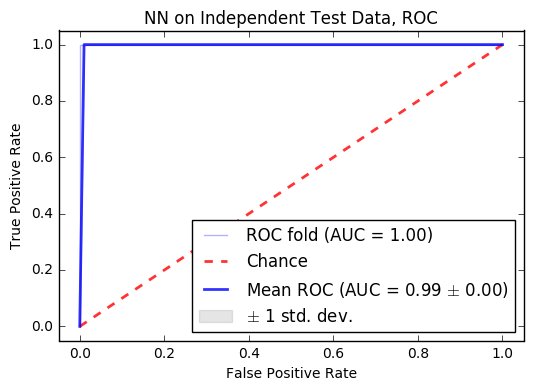

In [21]:
### ROC/AUC plotter
X_test = totalIndependentTestDataValues
# X_test = totalIndependentTestPCAFeatures[:,0:3]
Y_test = totalIndependentTestLabelValues
score = model.evaluate(X_test, Y_test, batch_size=32)
y_score = model.predict_proba(X_test)
i = 0

tprs=[] 
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fpr, tpr, thresholds = roc_curve(Y_test[:,i], y_score[:, i])
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold (AUC = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NN on Independent Test Data, ROC')
plt.legend(loc="lower right")
plt.show()

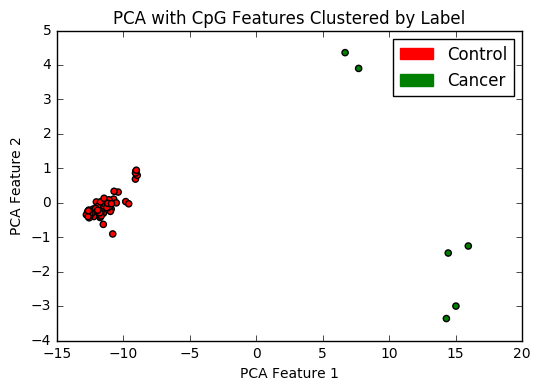

In [26]:
colors_label = [0 if label[0] == 0 else 1 for label in totalIndependentTestLabelValues]
p1 = plt.scatter(totalIndependentTestPCAFeatures[:, 0], totalIndependentTestPCAFeatures[:, 1], c=[colors[c] for c in colors_label])
plt.title("PCA with CpG Features Clustered by Label")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(handles=[mpatches.Patch(color='red', label='Control'),mpatches.Patch(color='green', label='Cancer')])
plt.show()

C:\Users\chsue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


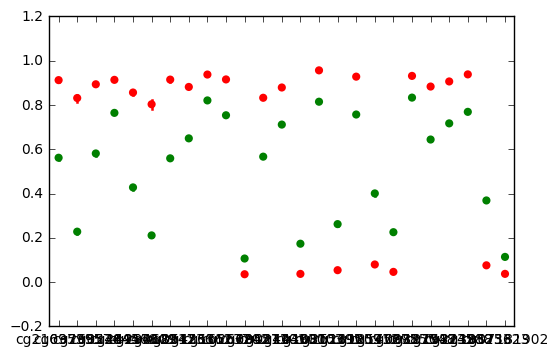

In [54]:
plottingData = pd.concat([totalData[keyCpG],pd.DataFrame(["Cancer"]*194+["Control"]*188,index=totalData.index,columns=["Sample"])],axis=1)
cancerMean = totalData[keyCpG].iloc[:194,:].mean(axis=0)
nonCancerMean=totalData[keyCpG].iloc[194:,:].mean(axis=0)
sns.pointplot(data=totalData[keyCpG].iloc[:194,:],color='r',join=False)
sns.pointplot(data=totalData[keyCpG].iloc[194:,0:],color='g',join=False)
plt.show()

In [ ]:
relatedCpgSites = ['cg06307913', 'cg18073471', 'cg11388320', 'cg26299084', 'cg04214966', 'cg27242132']
nonCancer = totalData.drop(["Cancer","Not Cancer"],axis=1).iloc[194:,:].loc[:,relatedCpgSites].mean(axis=0)
cancer = totalData.drop(["Cancer","Not Cancer"],axis=1).iloc[:194,:].loc[:,relatedCpgSites].mean(axis=0)
fig = plt.figure()
### plotting a single SNP against PCA Feature 1
total = pd.concat([nonCancer,cancer],axis=1)
plt.title("SNP 157 vs PCA Value")
ax = sns.pointplot(x=total.index,y=total[0],color='g')
sns.pointplot(x=total.index,y=total[1],color='r')
plt.show()


In [30]:
f = open("SignificantCpG_pVal1k_allData",'w')
for cpg in keyCpG:
    f.write(cpg + "\n")
f.close()

In [ ]:
totalData[keyCpG].loc["TCGA-AB-2831-03A-01D-0741-05"].sum()

In [35]:
totalData.iloc[:194,:].index

Index(['TCGA-AB-2802-03A-01D-0741-05', 'TCGA-AB-2803-03A-01D-0741-05',
       'TCGA-AB-2804-03A-01D-0741-05', 'TCGA-AB-2805-03A-01D-0741-05',
       'TCGA-AB-2806-03A-01D-0741-05', 'TCGA-AB-2807-03A-01D-0741-05',
       'TCGA-AB-2808-03A-01D-0741-05', 'TCGA-AB-2809-03A-01D-0741-05',
       'TCGA-AB-2810-03A-01D-0741-05', 'TCGA-AB-2811-03A-01D-0741-05',
       ...
       'TCGA-AB-3000-03A-01D-0741-05', 'TCGA-AB-3001-03A-01D-0741-05',
       'TCGA-AB-3002-03A-01D-0742-05', 'TCGA-AB-3005-03A-01D-0741-05',
       'TCGA-AB-3006-03A-01D-0741-05', 'TCGA-AB-3007-03A-01D-0741-05',
       'TCGA-AB-3008-03A-01D-0741-05', 'TCGA-AB-3009-03A-01D-0741-05',
       'TCGA-AB-3011-03A-01D-0742-05', 'TCGA-AB-3012-03A-01D-0741-05'],
      dtype='object', length=194)

In [55]:
keyCpG

Index(['cg21695395', 'cg03795574', 'cg26353844', 'cg02464568', 'cg24957609',
       'cg23462242', 'cg01891736', 'cg05456362', 'cg12511137', 'cg16567202',
       'cg26684511', 'cg09527301', 'cg02403931', 'cg14460003', 'cg10815395',
       'cg25261059', 'cg13920312', 'cg18545695', 'cg17727855', 'cg09827048',
       'cg19798735', 'cg15324288', 'cg22395253', 'cg18373623', 'cg07181902'],
      dtype='object')